In [1]:
import matplotlib
fontsize = 17
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': r'''\usepackage{fontspec}
    \setmainfont{Linux Libertine O}''',
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
matplotlib.rcParams.update(params)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import decimal

import astropy.constants as const
from astropy.table import Table, Column
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

In [3]:
def recompute_Tb(fp_MCMC, rp_MCMC, A_MCMC, planet, channel, rootpath):
    if channel=='ch1':
        wav=3.6e-6
    else:
        wav=4.5e-6
    
    nIters = 10000
    fp_MCMC = np.random.normal(fp_MCMC[0], np.mean(fp_MCMC[1:]), nIters)
    rp_MCMC = np.random.normal(rp_MCMC[0], np.mean(rp_MCMC[1:]), nIters)
    A_MCMC = np.random.normal(A_MCMC[0], np.mean(A_MCMC[1:]), nIters)
    
    tstar_b = compute_Tstarb(planet, channel, rootpath)
    tstar_b = np.random.normal(tstar_b[0], tstar_b[1], nIters)
    
    tday = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC/rp_MCMC**2)))**-1
    tnight = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC*(1-2*A_MCMC)/rp_MCMC**2)))**-1
    
    return np.array([np.nanmedian(tday), np.nanpercentile(tday, 84)-np.nanmedian(tday), np.nanmedian(tday)-np.nanpercentile(tday, 16),
            np.nanmedian(tnight), np.nanpercentile(tnight, 84)-np.nanmedian(tnight), np.nanmedian(tnight)-np.nanpercentile(tnight, 16)])

def compute_Tstarb(planet, channel, rootpath):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.nanmean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.nanmean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.nanmean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.nanmean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    # Get the phoenix file ready to compute the stellar brightness temperature
    teffStr = Tstar
    if teffStr <= 7000:
        teffStr = teffStr - (teffStr%100) + np.rint((teffStr%100)/100)*100
    elif teffStr > 7000:
        teffStr = teffStr - (teffStr%200) + np.rint((teffStr%200)/200)*200
    elif teffStr > 12000:
        teffStr = 12000
    teffStr = str(int(teffStr)).zfill(5)
    
    logg = data['st_logg'][nameIndex]
    if np.isnan(logg):
        logg = 4.5
    logg = logg - (logg%0.5) + np.rint((logg%0.5)*2)/2.
    logg = -logg
    feh = data['st_metfe'][nameIndex]
    if np.isnan(feh):
        feh = 0.
    feh = (feh - (feh%0.5) + np.rint((feh%0.5)*2)/2.)
    if feh<-2.:
        feh = (feh - (feh%1) + np.rint((feh%1)))
    
    webfolder = 'ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/'
    phoenixPath = rootpath+planet+'/phoenix/'
    phoenixWavFile = phoenixPath+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
    if not os.path.exists(phoenixPath):
        print('Downloading relevant PHOENIX wavelengths file...')
        os.mkdir(phoenixPath)
        try:
            _ = urllib.request.urlretrieve(webfolder+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', phoenixWavFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')

    webfolder += 'PHOENIX-ACES-AGSS-COND-2011/Z'+("{0:+.01f}".format(feh) if feh!=0 else '-0.0')+'/'

    webfile = ('lte'+teffStr
             +("{0:+.02f}".format(logg) if logg!=0 else '-0.00')
             +("{0:+.01f}".format(feh) if feh!=0 else '-0.0')
             +'.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

    phoenixSpectraFile = phoenixPath+webfile

    if not os.path.exists(phoenixSpectraFile):
        print('Downloading relevant PHOENIX spectra...')
        try:
            _ = urllib.request.urlretrieve(webfolder+webfile, phoenixSpectraFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')
    
    f = fits.open(phoenixSpectraFile)
    fStar = f[0].data*1e-1 # 'erg/s/cm^2/cm' to kg/s^3
    f.close()
    f = fits.open(phoenixWavFile)
    wavStar = f[0].data*1e-4 # angstrom to micron
    f.close()

    def planck(wav, T):
        intensity = (2.0*const.h.value*const.c.value**2) / ((wav**5) * (np.exp(const.h.value*const.c.value/(wav*const.k_B.value*T)) - 1.0))
        return intensity
    def fluxDiff(temp, fStarSummed, wavs):
        #factor of pi likely needed to account for emitting area (pi*rstar^2 where rstar=1)
        return (np.sum(planck(wavs, temp)*np.pi)-fStarSummed)**2
    temps = np.linspace(3000, 11000, 801, endpoint=True)
    if channel == 'ch1':
        incides = np.where(np.logical_and(wavStar < 4., wavStar > 3.))[0]
    else:
        incides = np.where(np.logical_and(wavStar < 5., wavStar > 4.))[0]
    diffs = [fluxDiff(temp, np.sum(fStar[incides]), wavStar[incides]*1e-6) for temp in temps]
    tstar_b = temps[np.argmin(diffs)]
    
    return tstar_b, Tstar_err
    
def compute_T0(planet):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    nIters = 10000
    Tstar = np.random.normal(Tstar, Tstar_err, nIters)
    a = np.random.normal(a, a_err, nIters)
    
    T0 = Tstar*np.sqrt(1/a)
    return np.array([np.median(T0), np.std(T0)])

In [4]:
mainpath   = '/home/taylor/Documents/Research/spitzer/MEGA/'
planets = np.array(['HD189733b', 'WASP-43b', 'Qatar-1b', 'HD209458b', 'CoRoT-2b',
                    'WASP-14b', 'WASP-19b', 'HAT-P-7b', 'WASP-18b', 'KELT-1b',
                    'KELT-16b', 'WASP-103b', 'MASCARA-1b', 'WASP-12b', 'WASP-12b_old',
                    'WASP-33b', 'KELT-9b'])
channels = ['ch2' for planet in planets]
temp_planets = ['_{'.join(planet.split('_'))+'}' if '_' in planet else planet for planet in planets]
fancy_planets = np.array([r'$\rm '+r'$-$\rm '.join(planet.split('-'))+r'$' for planet in temp_planets])

fancy_planets = fancy_planets.astype('<U30')
fancy_planets[fancy_planets=='$\\rm WASP$-$\\rm 12b_{old}$'] = '$\\rm WASP$-$\\rm 12b~(2010)$'
fancy_planets[fancy_planets=='$\\rm WASP$-$\\rm 12b$'] = '$\\rm WASP$-$\\rm 12b~(2013)$'\

twoLimits = True

In [5]:
plotMode = 'BLISS_v2_autoRun_POET'
fancy_labels = r'$\rm '+r'\textunderscore '.join(plotMode.split('_'))+r'$'

In [6]:
T0s = []
As = []
Bs = []
fps = []
offsets = []
rps = []
tNights = []
tDays = []
sigFs = []
sigF_photons = []
modeBICs = []
folders = []

for iterNum in range(len(planets)):
    channel = channels[iterNum]
    planet = planets[iterNum]

    # Figure out where files are saved
    phoption = ''
    foldername = ''
    rms = None
    with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if phoption=='' and lines[i][0]=='/':
            foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
            phoption = lines[i].split('/')[-1].strip()
            i += 1
            ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
            if np.all(ignoreFrames==['']):
                ignoreFrames = np.array([]).astype(int)
            else:
                ignoreFrames = ignoreFrames.astype(int)
            i += 1
            rms = float(lines[i])
        elif phoption!='' and lines[i][0]=='/':
            if float(lines[i+2]) < rms:
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            else:
                i += 3
    pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

    # Figure out what modes were run
    modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
    for i in range(len(pldFoldernames)):
        modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))
    
    if planet in ['CoRoT-2b', 'WASP-12b', 'WASP-12b_old', 'WASP-103b']:
        modes = np.array([mode for mode in modes if plotMode.replace('_POET','').replace('_unbinned','')==mode[:len(plotMode.replace('_POET','').replace('_unbinned',''))]])
    else:
        modes = np.array([mode for mode in modes if plotMode==mode[:len(plotMode)]])

    # If this method was not fully run for this planet+channel, skip it
    if len(modes)==0:
        print(plotMode, 'not run for', planet, channel)
        T0s.append([np.nan, np.nan])
        As.append([np.nan, np.nan, np.nan])
        Bs.append([np.nan, np.nan, np.nan])
        fps.append([np.nan, np.nan, np.nan])
        offsets.append([np.nan, np.nan, np.nan])
        rps.append([np.nan, np.nan, np.nan])
        tNights.append([np.nan, np.nan, np.nan])
        tDays.append([np.nan, np.nan, np.nan])
        sigFs.append([np.nan, np.nan, np.nan])
        sigF_photons.append(np.nan)
        modeBICs.append(np.nan)
        folders.append('None')
        continue

    BICs = []
    for mode in modes:
        if 'PLD' in plotMode:
            if channel=='ch2':
                folder='4um'
            else:
                folder='3um'
            if '3x3' in mode:
                folder += 'PLD_3x3/'
            else:
                folder += 'PLD_5x5/'
            savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
        else:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

        if not os.path.exists(savepath):
            BICs.append(np.nan)
        else:
            ResultMCMC = np.load(savepath)
            BICs.append(-2*ResultMCMC['evidenceB'][0])

    if np.all(np.isnan(BICs)):
        T0s.append([np.nan, np.nan])
        As.append([np.nan, np.nan, np.nan])
        Bs.append([np.nan, np.nan, np.nan])
        fps.append([np.nan, np.nan, np.nan])
        offsets.append([np.nan, np.nan, np.nan])
        rps.append([np.nan, np.nan, np.nan])
        tNights.append([np.nan, np.nan, np.nan])
        tDays.append([np.nan, np.nan, np.nan])
        sigFs.append([np.nan, np.nan, np.nan])
        sigF_photons.append(np.nan)
        modeBICs.append(np.nan)
        folders.append('None')
        continue

    mode = modes[np.nanargmin(BICs)]

    if 'PLD' in plotMode:
        if channel=='ch2':
            folder='4um'
        else:
            folder='3um'
        if '3x3' in mode:
            folder += 'PLD_3x3/'
        else:
            folder += 'PLD_5x5/'
        savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
    else:
        savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

    ResultMCMC = np.load(savepath)

    if planet=='KELT-1b':
        T0s.append([6518/np.sqrt(3.60), np.sqrt((50/np.sqrt(3.60))**2+(6518/(3.60)*0.04)**2)])
    else:
        T0s.append(compute_T0(planet))
    fps.append(ResultMCMC['fp']*1e6)
    offsets.append(ResultMCMC['offset'])
    rps.append(ResultMCMC['rp'])
    tNights.append(ResultMCMC['tNight'])
    tDays.append(ResultMCMC['tDay'])
    if planet=='MASCARA-1b' and 'PyMC3' in mode:
        As.append(ResultMCMC['A']*np.pi/2)
        Bs.append(-ResultMCMC['B']*np.pi/2)
        sigFs.append(ResultMCMC['sigF']*1e6)
    else:
        As.append(ResultMCMC['A'])
        Bs.append(ResultMCMC['B'])
        sigFs.append(ResultMCMC['sigF']*1e6)
    try:
        sigF_photons.append(ResultMCMC['sigF_photon_ppm'][0])
    except:
        if planet=='MASCARA-1b':
            sigF_photons.append(509/2.124)
        elif planet=='KELT-16b':
            sigF_photons.append(1642/1.799)
        else:
            sigF_photons.append(np.nan)
    modeBICs.append(BICs[np.nanargmin(BICs)])

    folders.append('/'.join(savepath.split('/')[:-1]))

    print(planet, channel, mode)

T0s = np.array(T0s).T
As = np.array(As).T
Bs = np.array(Bs).T
fps = np.array(fps).T
offsets = np.array(offsets).T
rps = np.array(rps).T
tNights = np.array(tNights).T
tDays = np.array(tDays).T
sigFs = np.array(sigFs).T
sigF_photons = np.array(sigF_photons)
modeBICs = np.array(modeBICs)
folders = np.array(folders)

order = np.argsort(T0s[0])

T0s = T0s[:,order]
As = As[:,order]
Bs = Bs[:,order]
fps = fps[:,order]
offsets = offsets[:,order]
rps = rps[:,order]
tNights = tNights[:,order]
tDays = tDays[:,order]
sigFs = sigFs[:,order]
sigF_photons = sigF_photons[order]
modeBICs = modeBICs[order]
folders = folders[order]
planets = planets[order]
fancy_planets = fancy_planets[order]

HD189733b ch2 BLISS_v2_autoRun_POET
WASP-43b ch2 BLISS_v2_autoRun_POET
Qatar-1b ch2 BLISS_v2_autoRun_POET
HD209458b ch2 BLISS_v2_autoRun_POET
CoRoT-2b ch2 BLISS_v2_autoRun
WASP-14b ch2 BLISS_v2_autoRun_POET
WASP-19b ch2 BLISS_v2_autoRun_POET
HAT-P-7b ch2 BLISS_v2_autoRun_POET
WASP-18b ch2 BLISS_v2_autoRun_POET
KELT-1b ch2 BLISS_v2_autoRun_POET
KELT-16b ch2 BLISS_v2_autoRun_POET
BLISS_v2_autoRun_POET not run for WASP-103b ch2
MASCARA-1b ch2 BLISS_v2_autoRun_POET
WASP-12b ch2 BLISS_v2_autoRun
WASP-12b_old ch2 BLISS_v2_autoRun
WASP-33b ch2 BLISS_v2_autoRun_POET
KELT-9b ch2 BLISS_v2_autoRun_POET


In [7]:
T0 = T0s.T[np.isfinite(T0s[0])]
Td = tDays.T[np.isfinite(T0s[0])]
Tn = tNights.T[np.isfinite(T0s[0])]
offset = offsets.T[np.isfinite(T0s[0])]
planets_temp = planets[np.isfinite(T0s[0])]
fancy_planets_temp = fancy_planets[np.isfinite(T0s[0])]

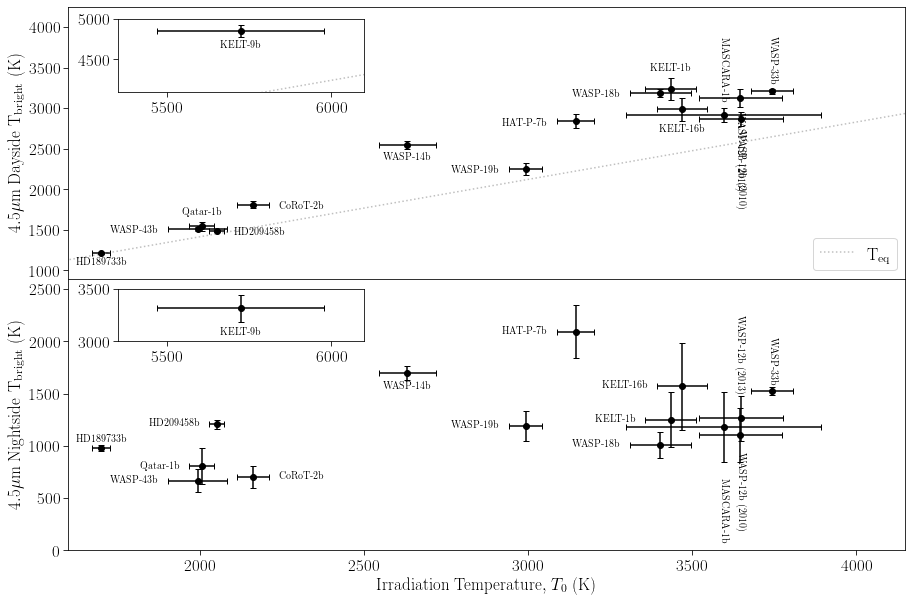

In [8]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(15,10))

ax[0].errorbar(T0[:,0], Td[:,0], xerr=T0[:,1], yerr=Td[:,1], fmt='o', color='k', capsize=3)
ax[0].plot([1000,4500], np.array([1000,4500])*0.25**0.25, c='grey', ls='dotted', alpha=0.5, label=r'$\rm T_{eq}$')
left=[1,6,7,8]
top=[2,9]
bottom=[0,5,10]
rotright=[12,13]
rotrightup=[11,14]
for i in range(len(planets_temp)-1):
    if i in left:
        ax[0].text(T0[i,0]-T0[i,1]-30, Td[i,0]-30, fancy_planets_temp[i], ha='right', va='center')
    elif i in top:
        ax[0].text(T0[i,0], Td[i,0]+Td[i,1]+60, fancy_planets_temp[i], ha='center', va='bottom')
    elif i in bottom:
        ax[0].text(T0[i,0], Td[i,0]-Td[i,1]-60, fancy_planets_temp[i], ha='center', va='top')
    elif i in rotright:
        ax[0].text(T0[i,0], Td[i,0]-Td[i,1]-60, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        ax[0].text(T0[i,0], Td[i,0]+Td[i,1]+60, fancy_planets[i], ha='center', va='bottom', rotation=-90)    
    else:
        ax[0].text(T0[i,0]+T0[i,1]+30, Td[i,0]-30, fancy_planets_temp[i], ha='left', va='center')
ax[0].set_xlim(1600,4150)
ax[0].set_ylim(900,4250)
ax[0].set_ylabel(r'$\rm 4.5\mu m~Dayside~T_{bright}~(K)$')
ax[0].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')
ax[0].legend(loc=4)
axin1 = ax[0].inset_axes([1750, 3200, 750, 900], transform=ax[0].transData)
axin1.errorbar(T0[:,0][-1], Td[:,0][-1], xerr=T0[:,1][-1], yerr=Td[:,1][-1], fmt='o', color='k', capsize=3)
axin1.text(T0[-1,0], Td[-1,0]-Td[-1,1]-60, fancy_planets_temp[-1], ha='center', va='top')
axin1.plot([1000,6500], np.array([1000,6500])*0.25**0.25, c='grey', ls='dotted', alpha=0.5)
axin1.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin1.set_xticks([5500,6000])
axin1.set_ylim(4100,5000)

ax[1].errorbar(T0[:,0], Tn[:,0], xerr=T0[:,1], yerr=Tn[:,1], fmt='o', color='k', capsize=3)
left=[1,2,3,6,7,8,9,10]
top=[0]
bottom=[5]
rotright=[11,13]
rotrightup=[12,14]
for i in range(len(planets_temp)-1):
    if i in left:
        ax[1].text(T0[i,0]-T0[i,1]-30, Tn[i,0]+0, fancy_planets_temp[i], ha='right', va='center')
    elif i in top:
        ax[1].text(T0[i,0], Tn[i,0]+Tn[i,1]*1.5, fancy_planets_temp[i], ha='center', va='bottom')
    elif i in bottom:
        ax[1].text(T0[i,0], Tn[i,0]-Tn[i,1]*1.5, fancy_planets_temp[i], ha='center', va='top')
    elif i in rotright:
        ax[1].text(T0[i,0], Tn[i,0]-Tn[i,1]*1.5, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        ax[1].text(T0[i,0], Tn[i,0]+Tn[i,1]*1.5, fancy_planets[i], ha='center', va='bottom', rotation=-90)    
    else:
        ax[1].text(T0[i,0]+T0[i,1]+30, Tn[i,0]+0, fancy_planets_temp[i], ha='left', va='center')
ax[1].set_ylim(0,2600)
ax[1].set_ylabel(r'$\rm 4.5\mu m~Nightside~T_{bright}~(K)$')
ax[1].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')
axin2 = ax[1].inset_axes([1750, 2000, 750, 500], transform=ax[1].transData)
axin2.errorbar(T0[:,0][-1], Tn[:,0][-1], xerr=T0[:,1][-1], yerr=Tn[:,1][-1], fmt='o', color='k', capsize=3)
axin2.text(T0[-1,0], Tn[-1,0]-Tn[-1,1]*1.5, fancy_planets_temp[-1], ha='center', va='top')
axin2.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin2.set_xticks([5500,6000])
axin2.set_ylim(3000,3500)

plt.savefig('../MEGA/figures/Tb_T0_Uniform.pdf', bbox_inches='tight')

plt.show()

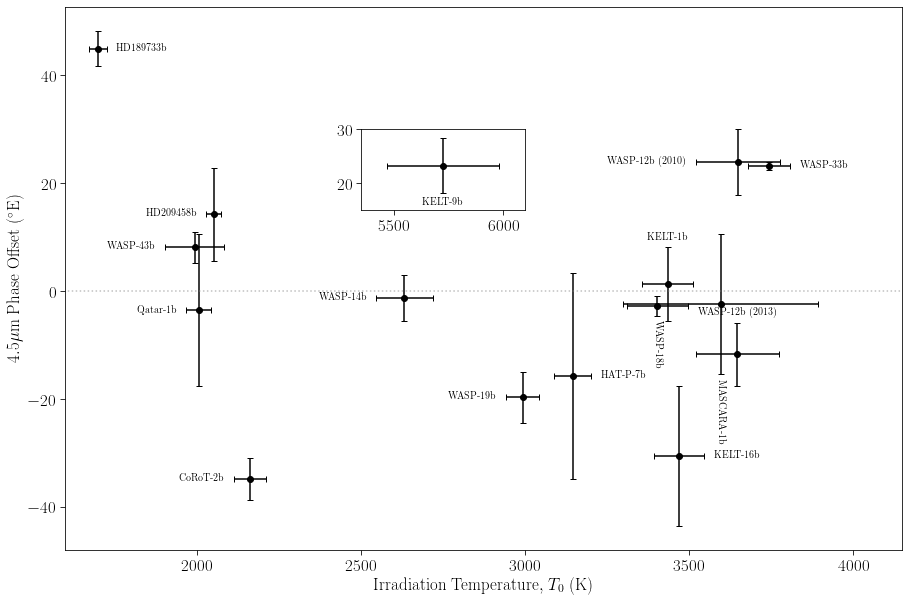

In [9]:
plt.figure(figsize=(15,10))
plt.errorbar(T0[:,0], offset[:,0], xerr=T0[:,1], yerr=offset[:,1], fmt='o', color='k', capsize=3)
left=[1,2,3,4,5,6,13]
bottom=[]
top=[9,12]
rotright=[8,11]
rotrightup=[]
for i in range(len(planets_temp)-1):
    if i in left:
        plt.text(T0[i,0]-T0[i,1]-30, offset[i,0]+0, fancy_planets_temp[i], ha='right', va='center')
    elif i in top:
        plt.text(T0[i,0], offset[i,0]+offset[i,1]+1, fancy_planets_temp[i], ha='center', va='bottom')
    elif i in bottom:
        plt.text(T0[i,0], offset[i,0]-offset[i,1]-1, fancy_planets_temp[i], ha='center', va='top')
    elif i in rotright:
        plt.text(T0[i,0], offset[i,0]-offset[i,1]-1, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        plt.text(T0[i,0], offset[i,0]+offset[i,1]+1, fancy_planets[i], ha='center', va='bottom', rotation=-90)    
    else:
        plt.text(T0[i,0]+T0[i,1]+30, offset[i,0]+0, fancy_planets_temp[i], ha='left', va='center')

plt.plot([1500,4150],[0,0],c='grey',ls='dotted',alpha=0.5)
plt.xlim(1600,4150)

ax = plt.gca()
axin1 = ax.inset_axes([2500, 15, 500, 15], transform=ax.transData)
axin1.errorbar(T0[:,0][-1], offset[:,0][-1], xerr=T0[:,1][-1], yerr=offset[:,1][-1], fmt='o', color='k', capsize=3)
axin1.text(T0[-1,0], offset[-1,0]-offset[-1,1]-1, fancy_planets_temp[-1], ha='center', va='top')
axin1.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin1.set_xticks([5500,6000])
axin1.set_ylim(15,30)


plt.ylabel(r'$\rm 4.5\mu m~Phase~Offset~(^{\circ}E)$')
plt.xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')

plt.savefig('../MEGA/figures/offset_T0_Uniform.pdf', bbox_inches='tight')
plt.show()

In [11]:
from SPCA import Decorrelation_helper as dh
from astropy.table import Table
from corner import corner
from tqdm import tqdm
from scipy.stats import pearsonr
rootpath = '/home/taylor/Documents/Research/spitzer/MEGA/'

In [15]:
import george
from george import kernels
from scipy.interpolate import interp1d
import scipy.constants as const2
import scipy.integrate as integral
c = const2.c
pi = const2.pi
h = const2.value('Planck constant')
k = const2.value('Boltzmann constant')
sig = const2.value('Stefan-Boltzmann constant')
const_1 = 2.0 * h * c ** 2
const_2 = h*c/k

# CONVERT BRIGHTNESS TEMPERATURE SPECTRUM TO EFFECTIVE TEMPERATURE
def Convert_to_T_eff(x, y):
    Temps = const_1 / (x ** 5 * (np.exp(const_2 / (x * y)) - 1))
    t_eff = abs(integral.trapz(Temps, x))
    t_eff = ((t_eff * pi) / sig) ** .25
    return t_eff


#  FIT BRIGHTNESS TEMPERATURE SPECTRUM WITH LINEAR INTERPOLATION METHOD
def linearInterpolation(domain, bds, y):
    LI = interp1d(bds, y)
    min_band = np.argmin(bds)
    max_band = np.argmax(bds)
    interp_y = [y[min_band] if wav < bds[min_band] else y[max_band] if wav > bds[max_band] else LI(wav) for wav in domain]
    return interp_y


#  ESTIMATE EFFECTIVE TEMPERATURE USING GP, LI, and EWM METHODS
def pass_uncerts(bds, y, yerr):
    domain = np.logspace(-7, -4, 100)
    divisor = 1e15
    
    domain_freq = np.array([c/lam/divisor for lam in domain])  # convert domain to frequency in petahertz
    new_bds = np.array([c / bd / divisor for bd in bds])  # convert bands to frequency in petahertz

    kernal_value = 0.1
    kern = kernels.ExpSquaredKernel(kernal_value)  # initialize covariance kernel

    functions_GP = []
    functions_LI = []

    randomized = np.array(list(map(np.random.normal, y, yerr, [100] * len(yerr)))).T
    ewms = []

    for y_rand in randomized:   # Monte Carlo

        # Error-weighted mean method
        av = np.average(y_rand, weights=1./yerr)
        ewms.append(av)

        # Setting up the GP
        y_rand /= av  # normalize the data
        model = george.GP(np.var(y_rand) * kern, mean=1.)
        model.compute(new_bds, yerr=yerr/av)

        # Setting the hyperparameters
        model["kernel:k1:log_constant"] = -4  # signal variance trained on exoplanets.org secondary eclipse sample
        model['kernel:k2:metric:log_M_0_0'] = -8.55  # length scale trained on HITEMP spectrum of water

        functions_GP.extend(model.sample_conditional(y_rand, domain_freq, 100) * av)  # 100 samples from posterior

    # calculate uncertainty & z-score for EMW method
    mean_mean = np.mean(ewms)
    std_mean = np.std(ewms)

    # convert brightness temperature functions to effective temperatures
    temps_GP = [Convert_to_T_eff(domain, pred) for pred in functions_GP]

    # calculate uncertainty & z-score for GP-fixed method
    mean_gp = np.mean(temps_GP)
    std_gp = np.std(temps_GP)

    return [mean_gp, std_gp]

In [16]:
archiveData = Table.to_pandas(Table.read('../masterfile.ecsv'))
names = np.array(archiveData['pl_hostname'])+np.array(archiveData['pl_letter'])
names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

In [66]:
plotData = []

for i in tqdm(range(len(planets))):
    channel = channels[i]
    planet = planets[i]
    
    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    mass = [archiveData['pl_massj'][nameIndex], np.mean([archiveData['pl_massjerr1'][nameIndex],
                                                         np.abs(archiveData['pl_massjerr2'][nameIndex])])]
    density = [archiveData['pl_dens'][nameIndex], np.mean([archiveData['pl_denserr1'][nameIndex],
                                                           np.abs(archiveData['pl_denserr2'][nameIndex])])]
    period = [archiveData['pl_orbper'][nameIndex], np.mean([archiveData['pl_orbpererr1'][nameIndex],
                                                            np.abs(archiveData['pl_orbpererr2'][nameIndex])])]
    
    feh = [archiveData['st_metfe'][nameIndex], np.mean([archiveData['st_metfeerr1'][nameIndex],
                                                        np.abs(archiveData['st_metfeerr2'][nameIndex])])]
    
    Tstar = [archiveData['st_teff'][nameIndex], np.mean([archiveData['st_tefferr1'][nameIndex],
                                                         np.abs(archiveData['st_tefferr2'][nameIndex])])]
    
    if np.isfinite(archiveData['pl_ratdor'][nameIndex]):
        a = archiveData['pl_ratdor'][nameIndex]
        a_err = np.mean([archiveData['pl_ratdorerr1'][nameIndex],
                         np.abs(archiveData['pl_ratdorerr2'][nameIndex])])
    else:
        a = archiveData['pl_orbsmax'][nameIndex]*const.au.value/archiveData['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([archiveData['pl_orbsmaxerr1'][nameIndex], np.abs(archiveData['pl_orbsmaxerr2'][nameIndex])])*const.au.value
             /archiveData['st_rad'][nameIndex]/const.R_sun.value)**2
            + (archiveData['pl_orbsmax'][nameIndex]*const.au.value
               /archiveData['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([archiveData['st_raderr1'][nameIndex], np.abs(archiveData['st_raderr2'][nameIndex])]))**2
        )
    a = [a, a_err]
        
    if planet=='KELT-1b':
        Tstar = [6518, 50]
        feh = [0.052,0.079]
    elif planet=='WASP-33b':
        feh = [0.10,0.]
    elif planet=='MASCARA-1b':
        feh = [0,0]
    
    if np.all(np.isnan(fps.T[i])):
        continue
    
    newTb = recompute_Tb(fps.T[i]/1e6, rps.T[i], As.T[i],
                         planet, channel, mainpath)
    Tday = newTb[[0,1,2]]
    Tnight = newTb[[3,4,5]]
    
    
    n = int(1.5e5)    
    Tstar = np.random.normal(Tstar[0],  Tstar[1], n)
    a = np.random.normal(a[0],  a[1], n)
    
    # Update day and nightside uncertainties using Pass+2019
    bands = np.array([4.493e-6])  # central wavelengths of observed bands (m)
    td_brights = np.array([Tday[0]])  # brightness temperatures in these bands (K)
    td_uncs = np.array([np.mean(Tday[1:])])  # uncertainties on brightness temperatures (K)
    tn_brights = np.array([Tnight[0]])  # brightness temperatures in these bands (K)
    tn_uncs = np.array([np.mean(Tnight[1:])])  # uncertainties on brightness temperatures (K)

    Tday = np.array(pass_uncerts(bands, td_brights, td_uncs))
    Tnight = np.array(pass_uncerts(bands, tn_brights, tn_uncs))

    Td = np.random.normal(Tday[0], Tday[1], n)
    Tn = np.random.normal(Tnight[0], Tday[1], n)
    
    n = np.min([Td.size, Tn.size, Tstar.size, a.size])
    Td = Td[np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][:n]
    Tn = Tn[np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][:n]
    a = a[np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][:n]
    Tstar = Tstar[:n]
    
    T0 = Tstar*np.sqrt(1/a)
    
    eps = 8/(5+3*(Td/Tn)**4) 
    AB = 1-(5*Tn**4+3*Td**4)/(2*T0**4)
    
    Tstar = np.append([np.median(Tstar)], np.mean(np.abs(np.percentile(Tstar, [16, 84])-np.median(Tstar))))
    T0 = np.append([np.median(T0)], np.mean(np.abs(np.percentile(T0, [16, 84])-np.median(T0))))
    eps = np.append([np.median(eps)], np.mean(np.abs(np.percentile(eps, [16, 84])-np.median(eps))))
    AB = np.append([np.median(AB)], np.mean(np.abs(np.percentile(AB, [16, 84])-np.median(AB))))
    
    A = np.array([As.T[i][0], np.mean(np.abs(As.T[i][1:]))])
    offset = np.array([offsets.T[i][0], np.mean(np.abs(offsets.T[i][1:]))])
    rp = np.array([rps.T[i][0], np.mean(np.abs(rps.T[i][1:]))])
    
    plotData.append([Tstar, T0s.T[i], Tday, Tnight, A, offset, eps, AB, rp, mass, density, period, feh])
    
plotData = np.array(plotData)


100%|██████████| 17/17 [01:17<00:00,  4.54s/it]


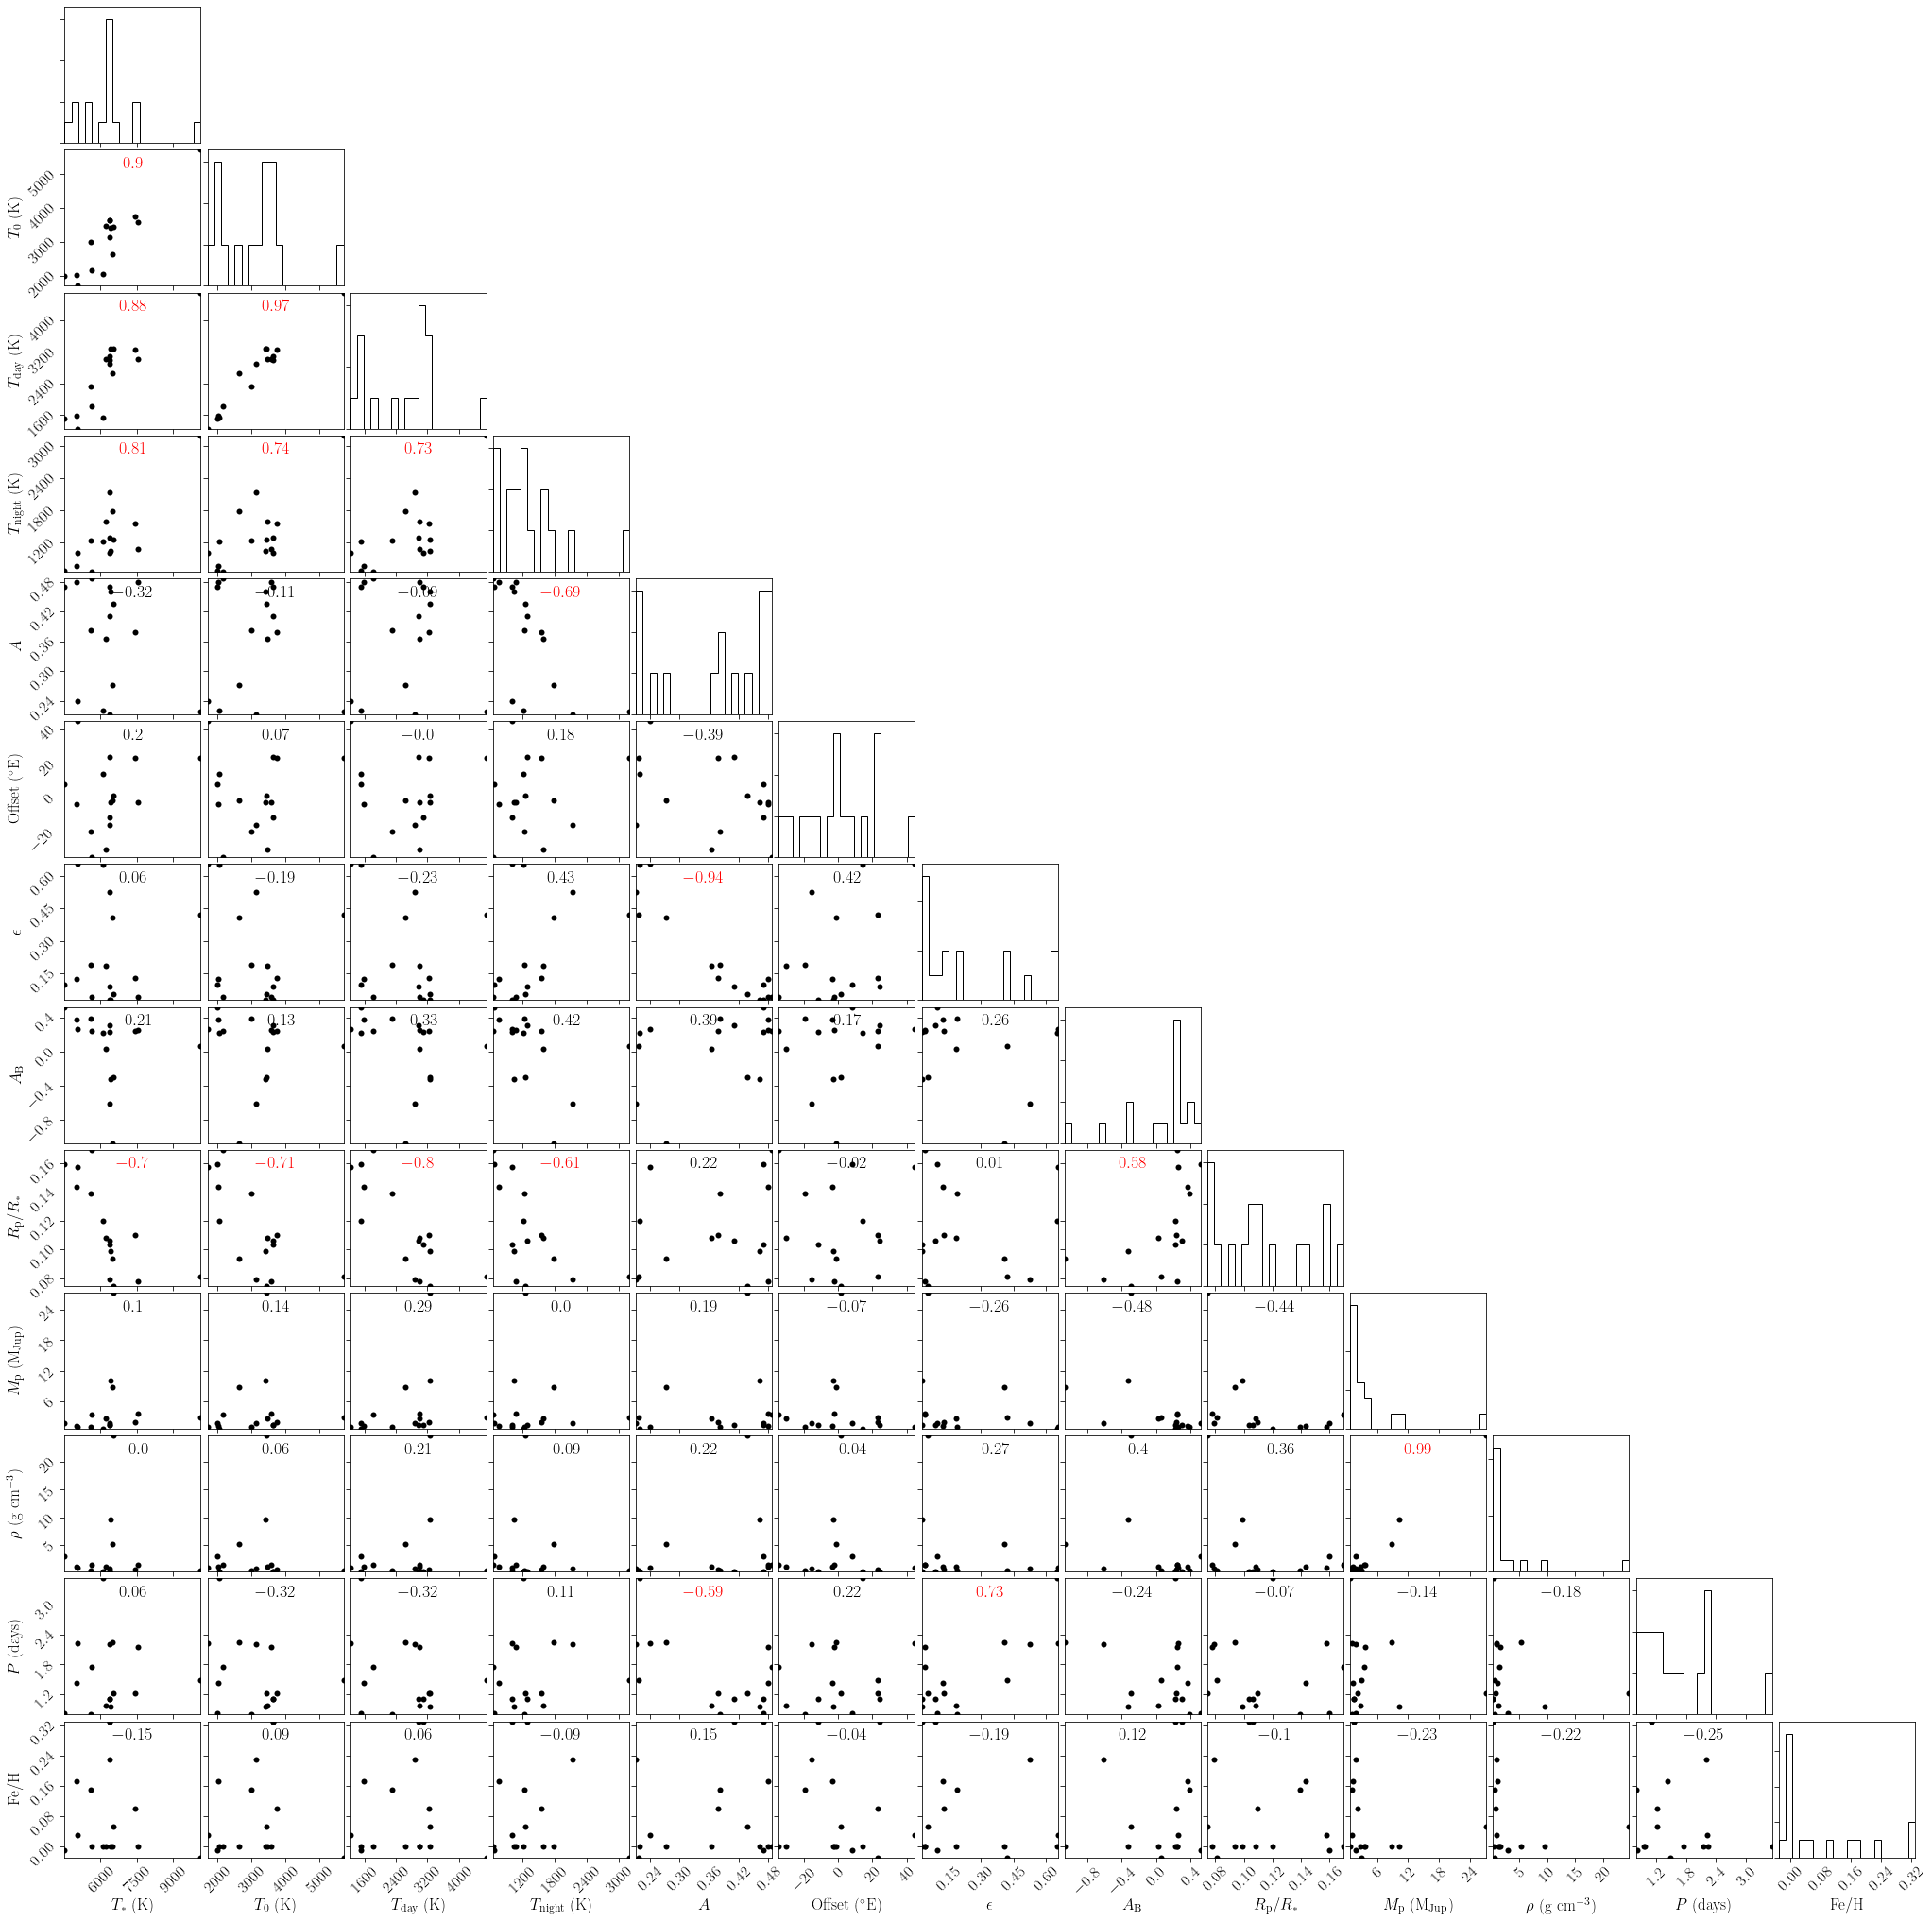

In [70]:
labels=[r'$T_{\rm *}~\rm (K)$', r'$T_{\rm 0}~\rm (K)$', r'$T_{\rm day}~\rm (K)$', r'$T_{\rm night}~\rm (K)$', r'$A$', r'$\rm Offset~\rm (^{\circ}E)$',
        r'$\epsilon$', r'$A_{\rm B}$', r'$R_{\rm p}/R_{\rm *}$', r'$M_{\rm p}~\rm (M_{\rm Jup})$', r'$\rho~\rm (g~cm^{-3})$', r'$P~\rm (days)$', r'$\rm Fe/H$']

corner(plotData[:,:,0], labels=labels,
       plot_datapoints=True, plot_density=False, plot_contours=False, data_kwargs={'ms':6, 'alpha':1, 'color':'k'})
figure = plt.gcf()

axes = np.array(figure.get_axes()).reshape(plotData.shape[1], plotData.shape[1])
for indX, x in enumerate(plotData[:,:,0].T):
    nameX = labels[indX]
    for indY, y in enumerate(plotData[:,(indX+1):,0].T):
        nameY = labels[(indX+1):][indY]
        r = pearsonr(x,y)
        axes[indY+indX+1, indX].text(0.5, 0.95, '$'+str(np.round(r[0], 2))+'$', horizontalalignment='center', verticalalignment='top', transform=axes[indY+indX+1, indX].transAxes, color=['black', 'red'][int(r[1]<0.05)], fontsize=18)

figure.patch.set_facecolor('white')
        
figure.savefig('/home/taylor/Downloads/PC_corner.pdf', bbox_inches='tight')
figure.savefig('/home/taylor/Downloads/PC_corner.png', dpi=300, bbox_inches='tight')
# plt.show()

1


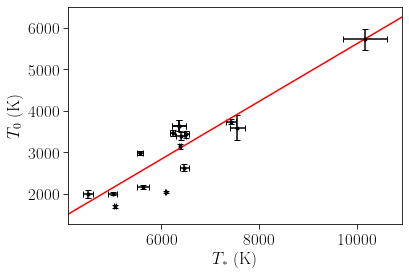

2


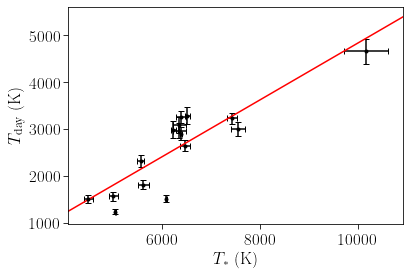

3


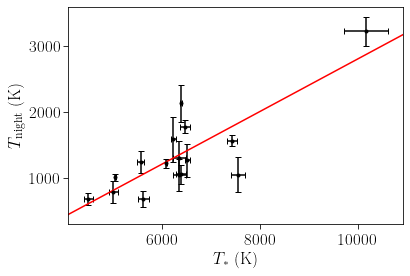

4


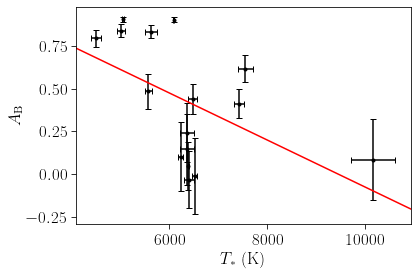

5


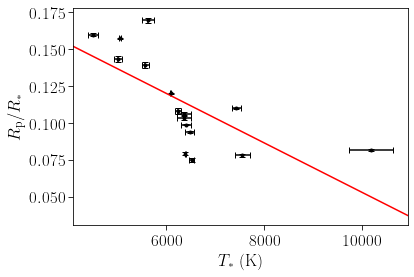

6


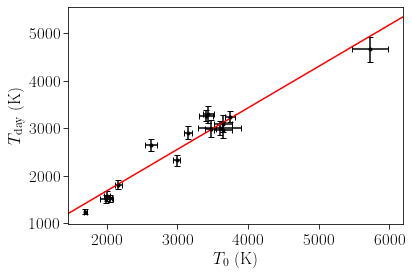

7


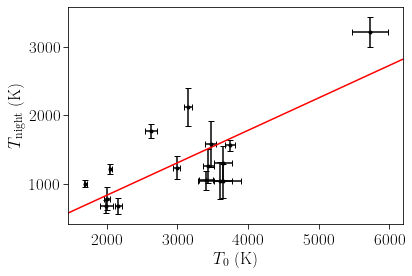

8


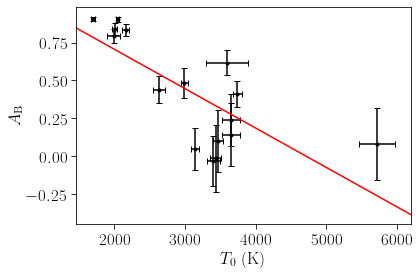

9


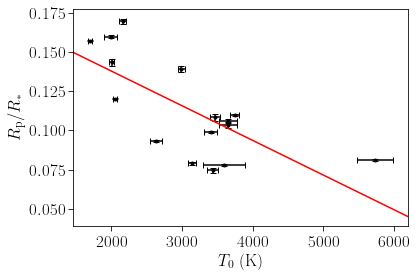

10


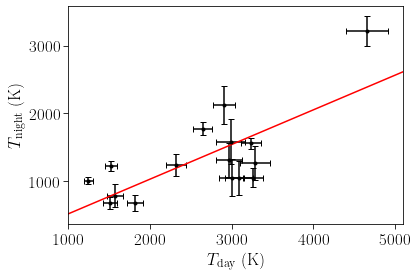

11


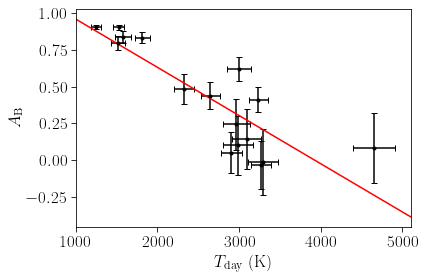

12


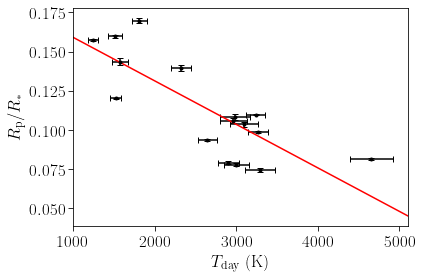

13


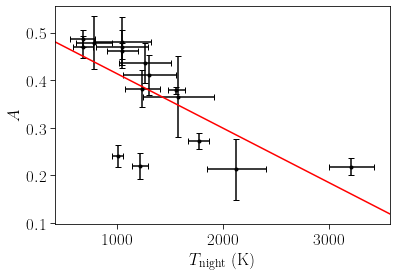

14


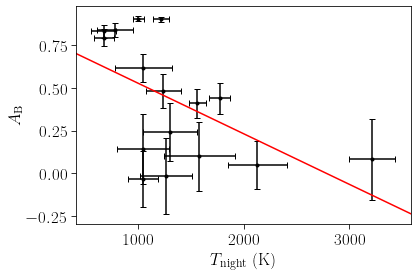

15


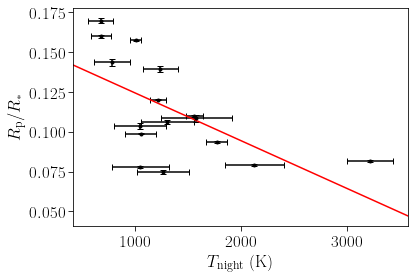

16


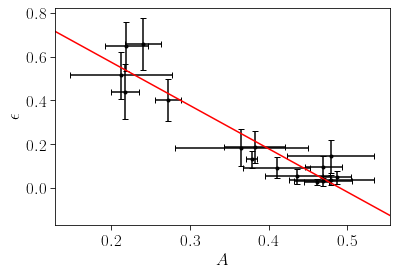

17


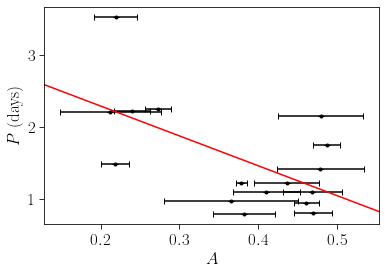

18


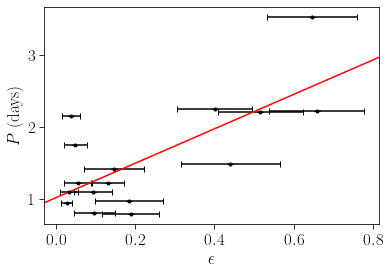

19


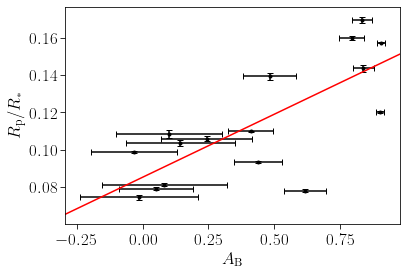

20


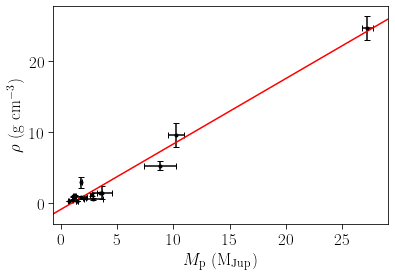

In [62]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            print(i)
            
            plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

            xlim = plt.gca().get_xlim()
            polyVars = np.polyfit(x, y, 1)
            x_smooth = np.linspace(xlim[0], xlim[1], 100)
            y_smooth = np.polyval(polyVars, x_smooth)
            plt.plot(x_smooth, y_smooth, '-', c='r')

            plt.xlim(*xlim)
            plt.ylabel(nameY)
            plt.xlabel(nameX)
            plt.show()